In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf


import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

import os
import random
import keras

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras import backend as K

In [2]:
!%pip install xlsxwriter

     |████████████████████████████████| 149 kB 516 kB/s            


In [4]:
import xlsxwriter

In [5]:
dataset_path = "../input/covid19-radiography-database/COVID-19_Radiography_Dataset"
covid_path = dataset_path + "/COVID"
lungOpacity_path = dataset_path + "/Lung_Opacity"
normal_path = dataset_path + "/Normal"
viralPneumonia_path = dataset_path + "/Viral Pneumonia"

labels_nos = ['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']

random.seed(100)
filesamples = random.sample(os.listdir(covid_path), 3) + random.sample(os.listdir(lungOpacity_path), 3) + random.sample(os.listdir(normal_path), 3) + random.sample(os.listdir(viralPneumonia_path), 3)

filenames = os.listdir(covid_path) + os.listdir(lungOpacity_path) + os.listdir(normal_path) + os.listdir(viralPneumonia_path)


def dataframe_generation(files):
    categories = []
    for filename in files:
        category = filename.split('-')[0]
        if category == labels_nos[0]:
            categories.append(str(0))
        elif category == labels_nos[1]:
            categories.append(str(1))
        elif category == labels_nos[2]:
            categories.append(str(2))
        elif category == labels_nos[3]:
            categories.append(str(3))

    for i in range(len(files)):
        if labels_nos[0] in files[i]:
            files[i] = os.path.join(covid_path, files[i])
        elif labels_nos[1] in files[i]:
            files[i] = os.path.join(lungOpacity_path, files[i])
        elif labels_nos[2] in files[i]:
            files[i] = os.path.join(normal_path, files[i])
        elif labels_nos[3] in files[i]:
            files[i] = os.path.join(viralPneumonia_path, files[i])
    
    df = pd.DataFrame({
        'filename': files,
        'category': categories
    })

    return df

df = dataframe_generation(filenames)
df_samples = dataframe_generation(filesamples)
df.head()

,filename,category
0,../input/covid19-radiography-database/COVID-19...,0
1,../input/covid19-radiography-database/COVID-19...,0
2,../input/covid19-radiography-database/COVID-19...,0
3,../input/covid19-radiography-database/COVID-19...,0
4,../input/covid19-radiography-database/COVID-19...,0


In [6]:
df.to_excel('output1.xlsx', sheet_name='Sheet1', engine='xlsxwriter')

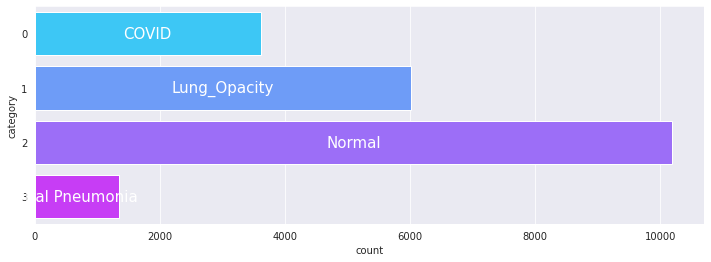

In [7]:
plt.figure(figsize=(12,4))
splot = sns.countplot(data = df.sort_values(by='category'), y ='category', palette='cool', saturation=0.9)
plt.bar_label(container=splot.containers[0], 
              labels= labels_nos, 
              label_type='center', size=15, color='w')
plt.show()

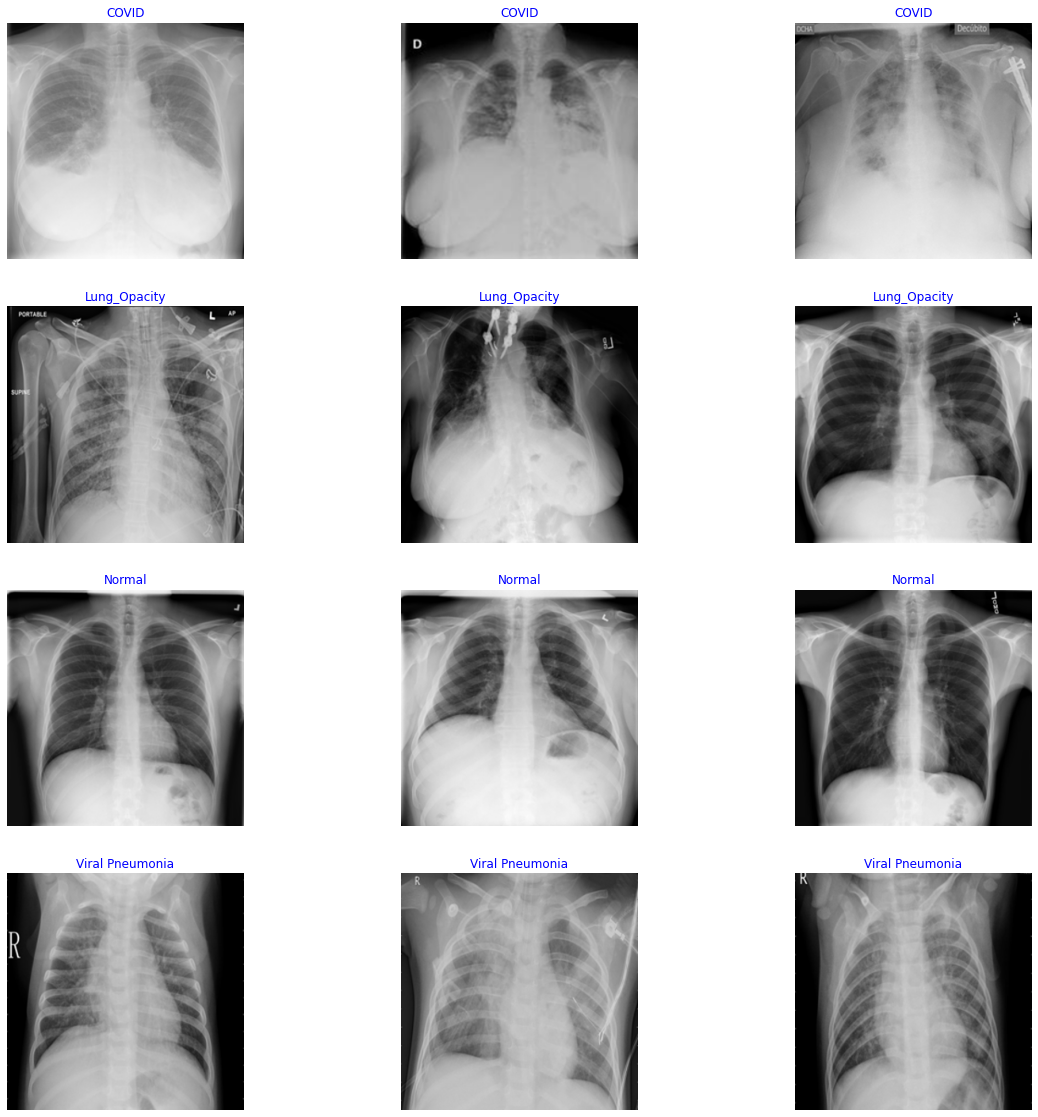

In [8]:
def show_image_samples(sample):
    simple_file = sample['filename']
    simple_label = sample['category']
    count = 0
    plt.figure(figsize=(20, 20))
    for i,y in zip(simple_file, simple_label):
        image = load_img(i)
        plt.subplot(4, 3, count + 1)
        plt.imshow(image)
        class_name = labels_nos[int(y)]
        plt.title(class_name, color='blue', fontsize=12)
        plt.axis('off')
        count = count+1
    plt.show()

show_image_samples(df_samples)

# difficoltà nel predire lung_opacity perchè le immagini sono molto simili alla categoria normal, verificare se lung_opacity è una categoria accettabile

In [9]:
random.seed(100)
reduced_dataset = random.sample(os.listdir(covid_path), 1000) + random.sample(os.listdir(lungOpacity_path), 1000) + random.sample(os.listdir(normal_path), 1000) + random.sample(os.listdir(viralPneumonia_path), 1000)

df_reduced = dataframe_generation(reduced_dataset)
df_reduced.head()

,filename,category
0,../input/covid19-radiography-database/COVID-19...,0
1,../input/covid19-radiography-database/COVID-19...,0
2,../input/covid19-radiography-database/COVID-19...,0
3,../input/covid19-radiography-database/COVID-19...,0
4,../input/covid19-radiography-database/COVID-19...,0


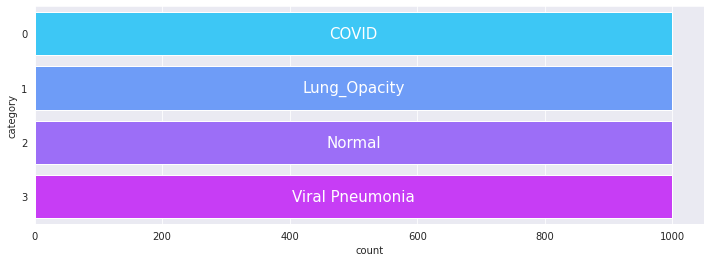

In [10]:
plt.figure(figsize=(12,4))
splot = sns.countplot(data = df_reduced.sort_values(by='category'), y ='category', palette='cool', saturation=0.9)
plt.bar_label(container=splot.containers[0], 
              labels= labels_nos, 
              label_type='center', size=15, color='w')
plt.show()

In [12]:
train_data, test_valid_data = train_test_split(df_reduced, test_size=0.2, random_state = 42, shuffle=True, stratify=df_reduced['category'])
train_data = train_data.reset_index(drop=True)
test_valid_data = test_valid_data.reset_index(drop=True)

In [13]:
test_data, valid_data = train_test_split(test_valid_data, test_size=0.5, random_state = 42,
                                         shuffle=True, stratify=test_valid_data['category'])
test_data = test_data.reset_index(drop=True)
valid_data = valid_data.reset_index(drop=True)

In [14]:
test_data.count()

filename    400
category    400
dtype: int64

In [15]:
train_data_gen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

In [16]:
train_generator = train_data_gen.flow_from_dataframe(
    train_data, 
    x_col='filename',
    y_col='category',
    target_size=(224,224),
    class_mode='categorical',
    batch_size=15
)

Found 3200 validated image filenames belonging to 4 classes.


In [17]:
valid_data_gen = ImageDataGenerator(rescale=1./255)

valid_generator = valid_data_gen.flow_from_dataframe(
    valid_data, 
    x_col='filename',
    y_col='category',
    target_size=(224,224),
    class_mode='categorical',
    batch_size=15
)

Found 400 validated image filenames belonging to 4 classes.


In [19]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [20]:
from tensorflow.keras.layers import Dense, Flatten, AveragePooling2D, Dropout

baseModel = VGG16(input_shape=(224,224,3), weights='imagenet', include_top=False)

for layer in baseModel.layers:
    layer.trainable = False

headModel = baseModel.output
headModel = AveragePooling2D()(headModel)
headModel = Flatten()(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.2)(headModel)
headModel = Dense(4, activation='softmax')(headModel)

model = tf.keras.Model(inputs=baseModel.input, outputs=headModel)

2022-01-24 11:12:54.797931: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-24 11:12:54.890045: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-24 11:12:54.890731: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-24 11:12:54.891819: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

58900480/58889256 [==============================] - 0s 0us/step


In [21]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [22]:
opt = Adam(learning_rate=0.0001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['acc',f1_m,precision_m, recall_m])

In [25]:
epochs = 15
history = model.fit(train_generator, validation_data=valid_generator, verbose=1, epochs=epochs, batch_size = 32)

Epoch 1/15
214/214 [==============================] - 50s 232ms/step - loss: 0.8103 - acc: 0.6872 - f1_m: 0.6120 - precision_m: 0.7970 - recall_m: 0.5056 - val_loss: 0.6996 - val_acc: 0.7675 - val_f1_m: 0.6956 - val_precision_m: 0.8215 - val_recall_m: 0.6086
Epoch 2/15
214/214 [==============================] - 44s 207ms/step - loss: 0.7215 - acc: 0.7259 - f1_m: 0.6770 - precision_m: 0.8025 - recall_m: 0.5916 - val_loss: 0.6473 - val_acc: 0.7600 - val_f1_m: 0.7363 - val_precision_m: 0.8196 - val_recall_m: 0.6728
Epoch 3/15
214/214 [==============================] - 44s 205ms/step - loss: 0.6633 - acc: 0.7497 - f1_m: 0.7178 - precision_m: 0.8162 - recall_m: 0.6464 - val_loss: 0.6131 - val_acc: 0.7825 - val_f1_m: 0.7366 - val_precision_m: 0.8224 - val_recall_m: 0.6716
Epoch 4/15
214/214 [==============================] - 45s 210ms/step - loss: 0.6363 - acc: 0.7578 - f1_m: 0.7331 - precision_m: 0.8212 - recall_m: 0.6670 - val_loss: 0.5835 - val_acc: 0.7775 - val_f1_m: 0.7567 - val_precisi

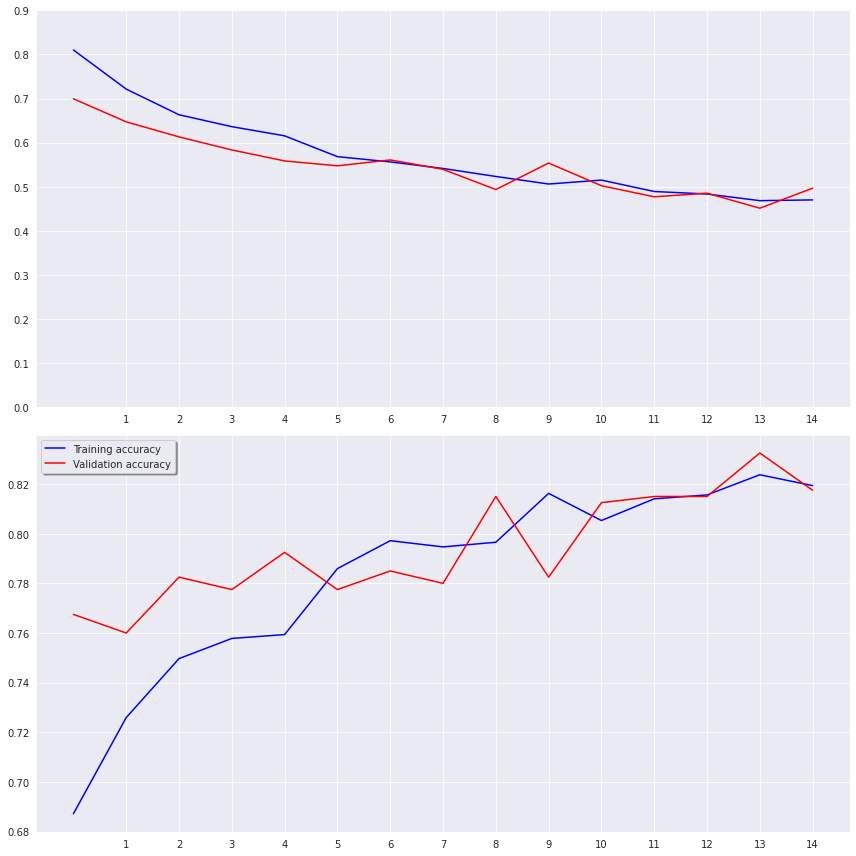

In [26]:
#epochs = 15

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['acc'], color='b', label="Training accuracy")
ax2.plot(history.history['val_acc'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

Confusion Matrix


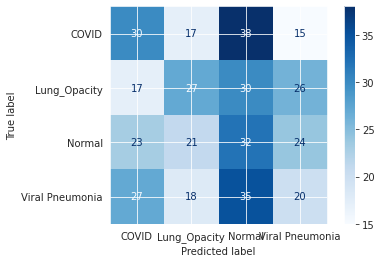

<Figure size 864x864 with 0 Axes>

Classification Report
                 precision    recall  f1-score   support

          COVID       0.31      0.30      0.30       100
   Lung_Opacity       0.33      0.27      0.30       100
         Normal       0.24      0.32      0.27       100
Viral Pneumonia       0.24      0.20      0.22       100

       accuracy                           0.27       400
      macro avg       0.28      0.27      0.27       400
   weighted avg       0.28      0.27      0.27       400



In [27]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
batch_size = 4
num_of_test_samples = 400
Y_pred = model.predict_generator(valid_generator, num_of_test_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=-1)

print('Confusion Matrix')
cm = confusion_matrix(valid_generator.classes, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_nos)

disp.plot(cmap=plt.cm.Blues)
plt.figure(figsize=(12, 12))
plt.show()

print('Classification Report')
target_names = labels_nos
print(classification_report(valid_generator.classes, y_pred, target_names=target_names))
